In [12]:
from sklearn.datasets import make_blobs
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [13]:
data = make_blobs(    
    n_samples=1000,
    n_features=2,
    centers=4,
    shuffle=True,
    random_state=2,)
X = np.array(data[0])
Y = data[1]

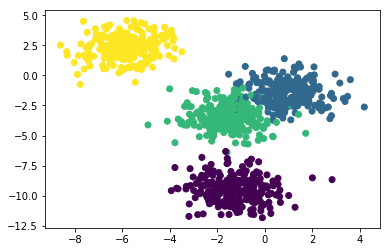

In [14]:
plt.scatter(X[:,0],X[:,1],c=Y)

In [15]:
XTrain,XTest,YTrain,YTest = train_test_split(X,Y,stratify=Y,random_state=0)
print(XTrain.shape,XTest.shape)

(750, 2) (250, 2)


In [16]:
XTrain,XTest,YTrain,YTest = map(torch.tensor,(XTrain,XTest,YTrain,YTest))

In [17]:
def model(x,weights,bias):
    z1=torch.matmul(weights[1],x.t().float()) + bias[1]
    a1=z1.sigmoid()
    z2=torch.matmul(weights[2],a1) + bias[2]
    a2 = z2.exp()/z2.exp().sum(0)
    return a2

In [18]:
def loss(y_hat,y):
    return -(y_hat[y,range(y_hat.shape[1])].log()).mean()

In [19]:
def accuracy(y_hat,y):
    pred = torch.argmax(y_hat,dim=0)
    return (pred==y).float().mean()

In [25]:
def score(x,y,weights,bias):
    y_hat = model(x,weights,bias)
    return accuracy(y_hat,y).item()

In [26]:
def train(X,Y,learning_rate=0.1,epochs=200):
    weights = {}
    bias = {}
    weights[1]=torch.randn([2,2])*0.01
    weights[1].requires_grad_()
    weights[2]=torch.randn([4,2])*0.01
    weights[2].requires_grad_()
    bias[1]=torch.ones([2,1],requires_grad=True)
    bias[2]=torch.ones([4,1],requires_grad=True)
    
    loss_arr = []
    acc_arr = []
    
    for i in range(epochs):
        y_hat = model(X,weights,bias)
        cost = loss(y_hat,Y)
        cost.backward()
        
        loss_arr.append(cost.item())
        acc_arr.append(accuracy(y_hat,Y).item())
        
        with torch.no_grad():
            weights[1]-=learning_rate*weights[1].grad
            weights[2]-=learning_rate*weights[2].grad
            bias[1]-=learning_rate*bias[1].grad
            bias[2]-=learning_rate*bias[2].grad
            
            weights[1].grad.zero_()
            weights[2].grad.zero_()
            bias[1].grad.zero_()
            bias[2].grad.zero_()
            
    return weights,bias,loss_arr,acc_arr         

In [27]:
weights,bias,loss_arr,acc_arr = train(XTrain,YTrain,learning_rate=0.1,epochs=4000)

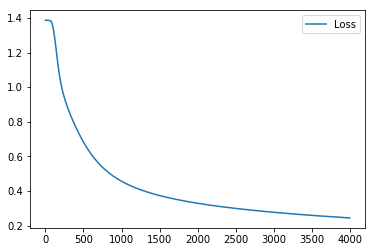

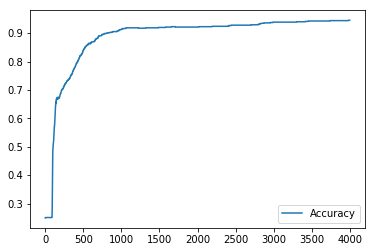

In [28]:
plt.plot(loss_arr,label='Loss')
plt.legend()
plt.show()
plt.plot(acc_arr,label='Accuracy')
plt.legend()
plt.show()

## Score on Test Data

In [29]:
score(XTest,YTest,weights,bias)

0.9480000138282776

## Using torch.nn

In [30]:
import torch.nn as nn
from torch.nn.functional import cross_entropy
from torch import optim

In [31]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model,self).__init__()
        ## Defining parameters
        self.lin1 = nn.Linear(2,2)
        self.lin2 = nn.Linear(2,4)
        self.lin3 = nn.Linear(4,4)
        
    def forward(self,X):
        a0 = X
        z1 = self.lin1(a0)
        a1 = torch.sigmoid(z1)
        z2 = self.lin2(a1)
        a2 = torch.sigmoid(z2)
        z3 = self.lin3(a2)
        a3 = z3.exp()/z3.exp().sum(-1,keepdim=True)
        return a3
    
def fit(X,Y,epochs=1000,learning_rate=1):
    
    loss_arr = []
    acc_arr = []
    optim1 = optim.SGD(fn.parameters(),lr=learning_rate)
    
    for _ in range(epochs):
        y_hat = fn(X)
        loss = cross_entropy(y_hat,Y)
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(y_hat.t(),Y).item())

        loss.backward()
        optim1.step()
        optim1.zero_grad()
        
    plt.plot(loss_arr,label='Loss')
    plt.plot(acc_arr,label='Accuracy')
    plt.legend()
    plt.show()
    print(loss_arr[0])
    print(loss_arr[-1])
    return fn.parameters

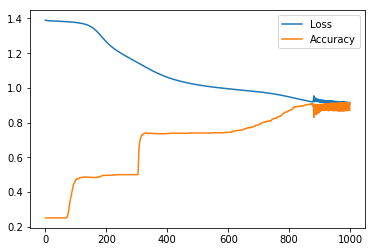

1.3899438381195068
0.9153504967689514


In [32]:
fn = Model()
parameters=fit(XTrain.float(),YTrain)

In [33]:
## Score of train data
y_hat = fn(XTrain.float())
print(accuracy(y_hat.t(),YTrain))

## Score of test data
y_hat_test = fn(XTest.float())
print(accuracy(y_hat_test.t(),YTest))

tensor(0.9160)
tensor(0.9000)


## Using nn.Sequential

In [34]:
class Model_v1(nn.Module):
    def __init__(self):
        super(Model_v1,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2,4),
            nn.ReLU(),
            nn.Linear(4,4),
            nn.Softmax()
        )
    def forward(self,X):
        return self.net(X)

/home/joshi_anurag/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


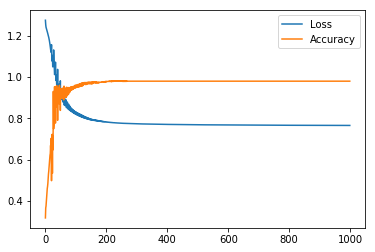

1.274682641029358
0.7659168839454651


In [35]:
fn=Model_v1()
parameters = fit(XTrain.float(),YTrain)

In [36]:
## Score of train data
y_hat = fn(XTrain.float())
print(accuracy(y_hat.t(),YTrain))

## Score of test data
y_hat_test = fn(XTest.float())
print(accuracy(y_hat_test.t(),YTest))

tensor(0.9800)
tensor(0.9800)


### Fit function

In [126]:
class Model_v1(nn.Module):
    def __init__(self):
        super(Model_v1,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2,8),
            nn.ReLU(),
            nn.Linear(8,4),
            nn.Softmax()
        )
    def forward(self,X):
        return self.net(X)

    
def fit(X,Y,model,opt,loss_fn,epochs=1000):
    for _ in range(epochs):
        loss = loss_fn(model(X),Y)

        loss.backward()
        opt.step()
        opt.zero_grad()
    
    print("final loss=",loss.item())

In [127]:
%%time
fn1=Model_v1()
opt = optim.RMSprop(fn1.parameters(),lr=0.1)
loss_fn = cross_entropy
fit(XTrain.float(),YTrain,fn1,opt,loss_fn,epochs=5000)

final loss= 0.7623401880264282
CPU times: user 14.8 s, sys: 6.3 s, total: 21.1 s
Wall time: 7.82 s


In [128]:
## Score of train data
y_hat = fn1(XTrain.float())
print(accuracy(y_hat.t(),YTrain))

## Score of test data
y_hat_test = fn1(XTest.float())
print(accuracy(y_hat_test.t(),YTest))

tensor(0.9813)
tensor(0.9840)


## Using GPU

In [129]:
cuda0 = torch.device('cuda:0') 
XTrain_GPU=XTrain.to(cuda0)
XTest_GPU=XTest.to(cuda0)
YTrain_GPU=YTrain.to(cuda0)
YTest_GPU=YTest.to(cuda0)

In [130]:
%%time
fn2=Model_v1()
fn2=fn1.to(cuda0)
opt = optim.Adam(fn2.parameters(),lr=0.01)
loss_fn = cross_entropy
fit(XTrain_GPU.float(),YTrain_GPU,fn2,opt,loss_fn,epochs=8000)

final loss= 0.762334942817688
CPU times: user 12.5 s, sys: 255 ms, total: 12.8 s
Wall time: 13.2 s


In [131]:
## Score of train data
y_hat = fn2(XTrain_GPU.float())
print(accuracy(y_hat.t(),YTrain_GPU))

## Score of test data
y_hat_test = fn2(XTest_GPU.float())
print(accuracy(y_hat_test.t(),YTest_GPU))

tensor(0.9813, device='cuda:0')
tensor(0.9840, device='cuda:0')
